In [18]:
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle

# Load environment variables
load_dotenv()
allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')

# Initialize BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

# Get ophys experiments
cell_exp = boc.get_ophys_experiments(experiment_container_ids=[511511001])

# Load Transformer embeddings
file_path = "/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224-in21k_embeddings.pkl"
with open(file_path, 'rb') as file:
    transfr = pickle.load(file)

movie_one = transfr['natural_movie_one']

embeddings=movie_one[:,0]

experiment_id = 506278598
data_set_regression = boc.get_ophys_experiment_data(experiment_id)
data_set_events = boc.get_ophys_experiment_events(experiment_id)

stim_table = data_set_regression.get_stimulus_table('natural_movie_one')
ts = stim_table[stim_table['repeat'] == 0]['start'].values

neuron=data_set_events[6,ts]
# Partition the embeddings into 5 levels based on quantiles
quantiles = np.percentile(embeddings, [20, 40, 60, 80])
bins = np.concatenate(([-np.inf], quantiles, [np.inf]))
levels = np.digitize(embeddings, bins) - 1  # Levels from 0 to 4
print(embeddings.shape)

event_values_per_level = []
for level in range(5):
    indices = np.where(levels == level)[0]
    event_values = neuron[indices]
    event_values_per_level.append(event_values)

event_values_per_level = np.array(event_values_per_level) 
print(event_values_per_level.shape)
#print(event_values_per_level)

event_values_nonzero=np.count_nonzero(event_values_per_level, axis=1)
event_values_nonzero

(900,)
(5, 180)


array([4, 1, 1, 3, 4])

(array([[0., 5., 0., 2., 0., 2., 1., 0., 0., 0.],
        [0., 4., 0., 2., 0., 1., 1., 0., 2., 0.],
        [1., 4., 0., 2., 0., 1., 2., 0., 0., 0.],
        [0., 1., 0., 3., 0., 4., 0., 0., 1., 1.],
        [1., 2., 0., 1., 0., 4., 1., 0., 0., 1.]]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 5 BarContainer objects>)

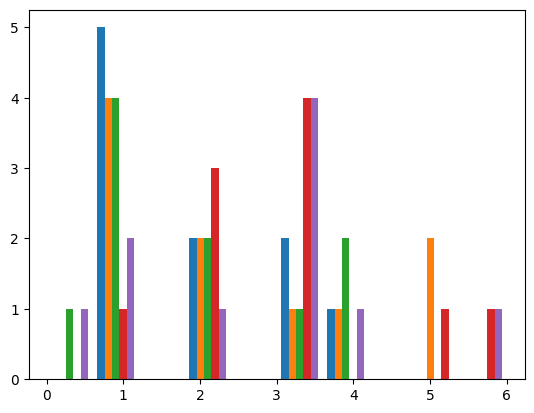

In [22]:
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle

# Load environment variables
load_dotenv()
allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')

# Initialize BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

# Get ophys experiments
cell_exp = boc.get_ophys_experiments(experiment_container_ids=[511511001])

# Load Transformer embeddings
file_path = "/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224-in21k_embeddings.pkl"
with open(file_path, 'rb') as file:
    transfr = pickle.load(file)

stimuli = transfr['natural_movie_one']

experiment_id = 506278598
data_set_regression = boc.get_ophys_experiment_data(experiment_id)
data_set_events = boc.get_ophys_experiment_events(experiment_id)

stim_table = data_set_regression.get_stimulus_table('natural_movie_one')

def generate_event_count_vector_levels(trial_ind, neuron_ind, transformer_emb_ind):
    ts = stim_table[stim_table['repeat'] == trial_ind]['start'].values
    neuron=data_set_events[neuron_ind,ts]
    embeddings = stimuli[:,transformer_emb_ind]
    # Partition the embeddings into 5 levels based on quantiles
    quantiles = np.percentile(embeddings, [20, 40, 60, 80])
    bins = np.concatenate(([-np.inf], quantiles, [np.inf]))
    levels = np.digitize(embeddings, bins) - 1 

    event_values_per_level = []
    for level in range(5):
        indices = np.where(levels == level)[0]
        event_values = neuron[indices]
        event_values_per_level.append(event_values)

    event_values_per_level = np.array(event_values_per_level)
    event_values_nonzero=np.count_nonzero(event_values_per_level, axis=1)

    return event_values_nonzero

neuron_trial_counts=[]

for trial in range(10):
    neuron_trial_counts.append(generate_event_count_vector_levels(trial, 6, 0))

neuron_trial_counts=np.array(neuron_trial_counts)

plt.hist(neuron_trial_counts)

In [27]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare the data
data = []
for trial_index in range(neuron_trial_counts.shape[0]):
    for level_index in range(neuron_trial_counts.shape[1]):
        count = neuron_trial_counts[trial_index, level_index]
        data.append({
            'Count': count,
            'Level': level_index,
            'Trial': trial_index
        })

df = pd.DataFrame(data)

# Fit Poisson regression model
model = smf.glm(formula='Count ~ C(Level)', data=df, family=sm.families.Poisson()).fit()

print(model.summary())

# Test the significance of the levels
if model.pvalues['C(Level)[T.1]'] < 0.05 or \
   model.pvalues['C(Level)[T.2]'] < 0.05 or \
   model.pvalues['C(Level)[T.3]'] < 0.05 or \
   model.pvalues['C(Level)[T.4]'] < 0.05:
    print("At least one level significantly predicts neuron event counts.")
else:
    print("Levels do not significantly predict neuron event counts.")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   50
Model:                            GLM   Df Residuals:                       45
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85.744
Date:                Tue, 03 Dec 2024   Deviance:                       43.364
Time:                        20:38:55   Pearson chi2:                     41.3
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07372
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6419      0.229      2.798